# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Max Lindquist

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [16]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#from keras.models import Sequential
#from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [3]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

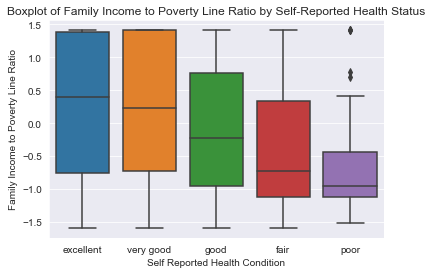

In [4]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

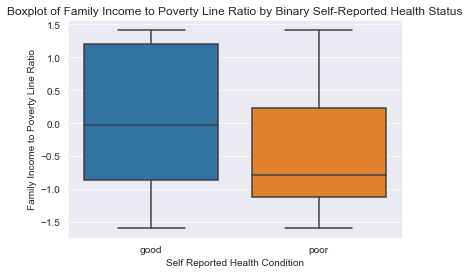

In [5]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

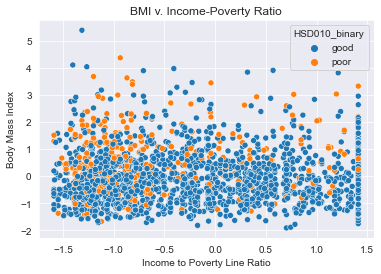

In [6]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010_binary", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [7]:
nhanes_scaled_a = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

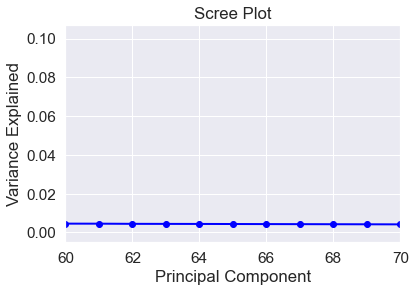

In [33]:
#
# Create a Scree plot to evaluate the number of components to keep
# --------------------------------------------------

# fit PCA
# ----------
pca_all = PCA() # notice we do not specify the number of components if we want to keep them all
principalComponents_nhanes_scaled = pca_all.fit_transform(nhanes_scaled_a)


# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xlim(60, 70)  # Set x-axis range from 0 to 100
plt.show()

## Number of Principal Components Chosen 

I will use three components to fit my model. I was originally planning on running four components based off of my scree plot (which shows only marginal gains in the variance explained ratio after four), but after doing a 2D scatterplot (not shown) on four components and generating fairly noisy results,  I decided on three.

In [28]:
pca = PCA(n_components=3)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled_a)
pca_df = pd.DataFrame(data = principalComponents_nhanes, 
                      columns = ['pc 1', 
                                 'pc 2',
                                'pc 3'
                                ])
pca_df

,pc 1,pc 2,pc 3
0,9.527811,-0.816232,-1.866835
1,-5.838339,-3.692568,3.805483
2,-0.719454,-2.573199,0.907826
3,3.533626,-2.576976,-3.249402
4,-6.872094,-4.194244,0.886954
...,...,...,...
2059,2.643319,-1.689353,-0.702571
2060,1.037906,-0.118066,5.556563
2061,1.130253,-0.970440,3.415570
2062,7.145093,-0.376745,1.753412


### Barplot of Components

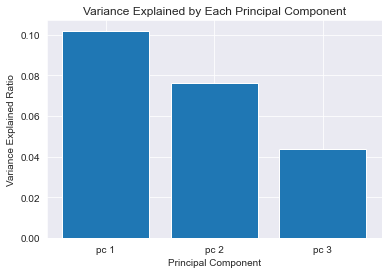

In [11]:
# Bar plot
plt.bar(pca_df.columns, pca.explained_variance_ratio_)
plt.title('Variance Explained by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained Ratio')
plt.show()

In [42]:
pca = PCA()
pca.fit(nhanes_scaled_a)
cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
desired_var_threshold = 0.95
num_components = np.argmax(cumulative_var_ratio >= desired_var_threshold) + 1
num_components

145

### How many components will you use to fit a supervised learning model?

I should use 145 components to fit a supervised learning model, as that number of components explains 95% of the variance in the original dataset.

### 2D Scatterplot of the first two components

In [12]:
# Resetting the indices to ensure alignment
nhanes_scaled_reset = nhanes_scaled.reset_index(drop=True)
pca_df_reset = pca_df.reset_index(drop=True)

# Adding 'HSD010_binary' values to 'pca_df'
pca_df_reset['HSD010_binary'] = nhanes_scaled_reset['HSD010_binary']
pca_df_reset

,pc 1,pc 2,pc 3,HSD010_binary
0,9.527811,-0.816227,-1.867100,good
1,-5.838339,-3.692569,3.805564,good
2,-0.719454,-2.573202,0.907828,good
3,3.533626,-2.576973,-3.249129,good
4,-6.872094,-4.194242,0.886940,good
...,...,...,...,...
2059,2.643319,-1.689354,-0.702505,good
2060,1.037906,-0.118061,5.556653,good
2061,1.130254,-0.970441,3.415208,poor
2062,7.145093,-0.376753,1.753671,good


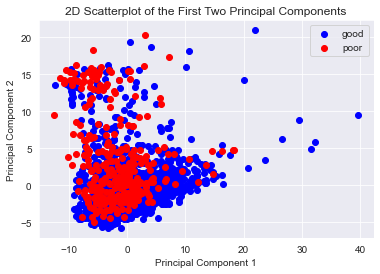

In [14]:
# Separate scatter plots for each category
plt.scatter(pca_df_reset[pca_df_reset['HSD010_binary'] == "good"]['pc 1'],
            pca_df_reset[pca_df_reset['HSD010_binary'] == "good"]['pc 2'],
            c='blue', label='good')

plt.scatter(pca_df_reset[pca_df_reset['HSD010_binary'] == "poor"]['pc 1'],
            pca_df_reset[pca_df_reset['HSD010_binary'] == "poor"]['pc 2'],
            c='red', label='poor')

# Create legends
plt.legend()

plt.title('2D Scatterplot of the First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [30]:
#
# using PCA Features
# --------------------------------------------------------


# create target dataset
# ----------
pca_df_reset['HSD010_binary'] = pca_df_reset['HSD010_binary'].replace({'good': 1, 'poor': 0})

y = pca_df_reset['HSD010_binary']


# create features dataset 
# ----------
X = pca_df


# split data
# ----------
X_train, X_test, y_train, y_test = train_test_split(X,                # specify features
                                                    y,                # specify labels
                                                    train_size = .80, # specify training data
                                                    test_size=0.20,   # specify test data
                                                    random_state=10)  # set seed

# initalize a logistic regresssion model
# ----------
logit_reg = LogisticRegression(max_iter= 5000) 


# fit the model
# ----------
logit_model = logit_reg.fit(X_train, 
                            y_train)

# predict on test set
# ----------
y_pred = logit_model.predict(X_test)



from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")


Accuracy: 0.84
F1 Score: 0.91
Precision: 0.85
Recall: 0.98


### Scatterplot Results
The first two components from the PCA model do a decent do decent job clustering good and poor health ratings, with the former appearing to be more associated with higher values of PC1.

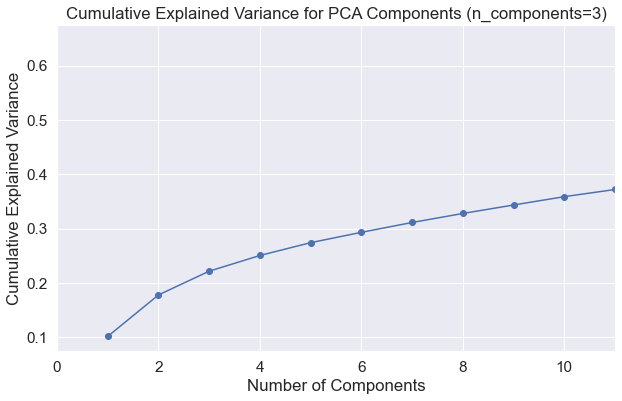

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming nhanes_scaled_a is your scaled data
pca = PCA(n_components=50)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled_a)

# Calculate cumulative explained variance
cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, marker='o', linestyle='-', color='b')
plt.title('Cumulative Explained Variance for PCA Components (n_components=3)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.grid(True)
plt.show()

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

K-Means is an unsupervised machine learning algorithm that divides a dataset into a pre-set number of clusters by iteratively assigning data points to the cluster with the nearest center and updating the centers based on the mean of the assigned points. K-Means minimizes the sum of squared distances between data points and their assigned centers, resulting in distinct and non-overlapping clusters.








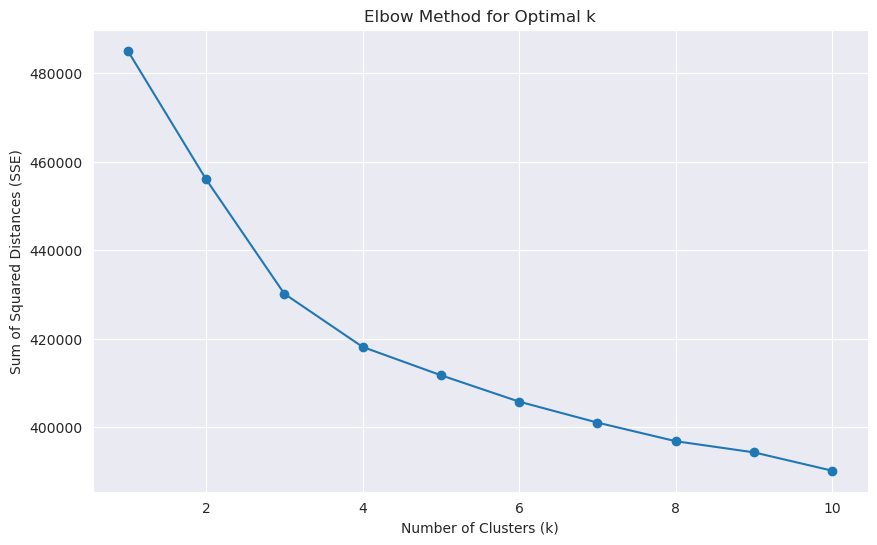

In [124]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming nhanes_scaled_a is your scaled data without the target variable
X = nhanes_scaled_a

# Create an empty list to store the sum of squared distances for each k
sse = []

# Specify a range of values for k (number of clusters)
k_range = range(1, 11)

# Fit k-means clustering for each value of k and calculate SSE
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.show()

### Cluster Selection
Based off of the elbow method, I will chose four clusters.

### Cluster nhanes

In [47]:
kmeans = KMeans(n_clusters=4,
                n_init=10,
                max_iter=300 #default
                ).fit(nhanes_scaled_a)

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

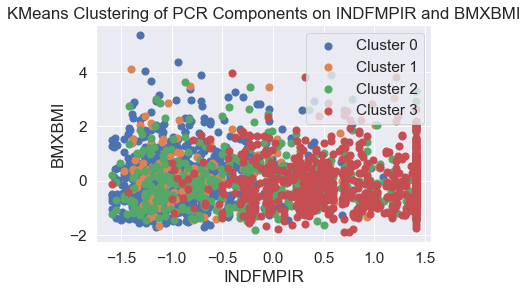

In [49]:
# figure settings
fig, ax1 = plt.subplots()

# Plot points by cluster
for cluster_label in range(4):
    ax1.scatter(
        nhanes_scaled_a.loc[kmeans.labels_ == cluster_label, 'INDFMPIR'],
        nhanes_scaled_a.loc[kmeans.labels_ == cluster_label, 'BMXBMI'],
        s=50,
        label=f'Cluster {cluster_label}'
    )

# Plot cluster centers
#ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='black', marker='+', label='Cluster Centers')

# Set labels and legend
ax1.set_xlabel('INDFMPIR')
ax1.set_ylabel('BMXBMI')
ax1.legend(loc='upper right')

plt.title('KMeans Clustering of PCR Components on INDFMPIR and BMXBMI')
plt.show()

I see four clusters, one of which (Clusters 3) is fairly distinct. Cluster 3 appears to capture people with high income to poverty line ratios. There appears to be three clusters for people with low income to poverty line ratios.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [50]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming nhanes_scaled_a is your data (Pandas DataFrame)
#pca_df = pca_df.drop(['HSD010_binary'], axis = 1)


# Resetting the indices to ensure alignment
nhanes_scaled_reset = nhanes_scaled.reset_index(drop=True)
pca_df_reset = pca_df.reset_index(drop=True)

 #Adding 'INDFMPIR','BMXBMI' values to 'pca_df'
pca_df_reset[['INDFMPIR', 'BMXBMI']] = nhanes_scaled_reset[['INDFMPIR', 'BMXBMI']]
#pca_df = pca_df_reset


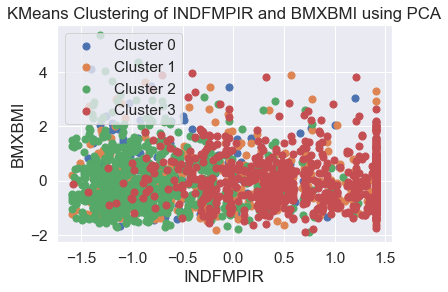

In [53]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming nhanes_scaled_a is your data (Pandas DataFrame)

# Fit the KMeans model
kmeans_pca = KMeans(n_clusters=4, n_init=10, max_iter=300).fit(pca_df)

# figure settings
fig, ax1 = plt.subplots()

# Plot points by cluster
for cluster_label in range(4):
    ax1.scatter(
        pca_df_reset.loc[kmeans_pca.labels_ == cluster_label, 'INDFMPIR'],
        pca_df_reset.loc[kmeans_pca.labels_ == cluster_label, 'BMXBMI'],
        s=50,
        label=f'Cluster {cluster_label}'
    )

# Plot cluster centers
#ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='black', marker='+', label='Cluster Centers')

# Set labels and legend
ax1.set_xlabel('INDFMPIR')
ax1.set_ylabel('BMXBMI')
ax1.legend(loc='upper left')

plt.title('KMeans Clustering of INDFMPIR and BMXBMI using PCA')
plt.show()

## Your Answer Here

I see two primary clusters: Cluster 3 and Cluster 2, but of which center around low- and high income to poverty to poverty ratios, respectively.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [129]:
# partition data
# -----------
column_name = 'HSD010_binary'

# Assuming 'good' should be recoded as 1 and 'poor' as 0
recode_dict = {'good': 1, 'poor': 0}

# Use the replace method to recode the values
nhanes_scaled[column_name] = nhanes_scaled[column_name].replace(recode_dict)
columns_to_drop = ['HSD010_binary', 'HSD010']
# Use the drop method to remove the specified columns
nhanes_scaled1 = nhanes_scaled.drop(columns=columns_to_drop)
y = nhanes_scaled['HSD010_binary'] # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already
# Assuming 'HSD010_binary' and 'HSD010' are the columns you want to drop
columns_to_drop = ['HSD010_binary', 'HSD010']
X = nhanes_scaled.drop(columns=columns_to_drop)
 # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [130]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = len(set(y_train))
# convert class vectors to binary class matrices
y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes)
#num_classes = y_test.shape[1]

In [131]:
# create neural network model
# -----------
input_dim = X_train.shape[1]

model = Sequential()

# Add the first dense layer
model.add(Dense(units=64, input_dim=input_dim, kernel_initializer='uniform', activation='relu'))

# Add the second dense layer (adjust the units as needed)
model.add(Dense(units=32, kernel_initializer='uniform', activation='relu'))

# Add the output layer with softmax activation for multi-class classification
model.add(Dense(units=num_classes, kernel_initializer='uniform', activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

# Fit the model
model.fit(X_train, y_train_categorical, validation_data=(X_test, y_test_categorical), epochs=10, batch_size=32, verbose=1)



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                15488     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 2)                 66        
                                                                 
Total params: 17,634
Trainable params: 17,634
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
49/49 [==============================] - 1s 5ms/step - loss: 0.5087 - accuracy: 0.8353 - val_loss: 0.3619 - val_accuracy: 0.8488
Epoch 2/10
49/49 [==============================] - 0s 2ms/step - loss: 0.3410 - accuracy: 0.8359 - val_loss: 0.3386 - val_accuracy: 0.8488
Epoch 3/10
49/49 [================

In [132]:
# Evaluate of the model
# ----------
scores = model.evaluate(X_test, y_test_categorical, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

CNN Error: 14.53%


### Neural Network on Principal Components

In [138]:
# partition data
# -----------
# Resetting the indices to ensure alignment
nhanes_scaled_reset = nhanes_scaled.reset_index(drop=True)
pca_df_reset = pca_df.reset_index(drop=True)

# Adding 'HSD010_binary' values to 'pca_df'
pca_df_reset['HSD010_binary'] = nhanes_scaled_reset['HSD010_binary']
column_name = 'HSD010_binary'

# Assuming 'good' should be recoded as 1 and 'poor' as 0
recode_dict = {'good': 1, 'poor': 0}
pca_df_reset[column_name] = pca_df_reset[column_name].replace(recode_dict)

# Use the replace method to recode the values
#pca_df_reset[column_name] = pca_df_reset[column_name].replace(recode_dict)
#columns_to_drop = ['HSD010_binary', 'HSD010']


In [140]:
columns_to_drop = ['HSD010_binary']
y = pca_df_reset['HSD010_binary'] # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already
# Assuming 'HSD010_binary' and 'HSD010' are the columns you want to drop
columns_to_drop1 = ['HSD010_binary']
X = pca_df_reset.drop(columns=columns_to_drop1)
 # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [141]:
# create neural network model
# -----------
input_dim = X_train.shape[1]

model = Sequential()

# Add the first dense layer
model.add(Dense(units=64, input_dim=input_dim, kernel_initializer='uniform', activation='relu'))

# Add the second dense layer (adjust the units as needed)
model.add(Dense(units=32, kernel_initializer='uniform', activation='relu'))

# Add the output layer with softmax activation for multi-class classification
model.add(Dense(units=num_classes, kernel_initializer='uniform', activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

# Fit the model
model.fit(X_train, y_train_categorical, validation_data=(X_test, y_test_categorical), epochs=10, batch_size=32, verbose=1)

# Evaluate of the model
# ----------
scores = model.evaluate(X_test, y_test_categorical, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                256       
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 2)                 66        
                                                                 
Total params: 2,402
Trainable params: 2,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
49/49 [==============================] - 1s 5ms/step - loss: 0.5796 - accuracy: 0.8353 - val_loss: 0.4007 - val_accuracy: 0.8488
Epoch 2/10
49/49 [==============================] - 0s 2ms/step - loss: 0.3861 - accuracy: 0.8359 - val_loss: 0.3755 - val_accuracy: 0.8488
Epoch 3/10
49/49 [==================

### Neural Network on Principal Components + Cluster Membership

In [150]:
kmeans_pca = KMeans(n_clusters=4, n_init=10, max_iter=300).fit(pca_df)
# Assuming kmeans_pca.labels_ contains the cluster labels
cluster_labels = kmeans_pca.labels_

# Concatenate cluster labels with principal components
X_with_clusters = pd.concat([pca_df_reset.drop(columns=columns_to_drop), pd.Series(cluster_labels, name='Cluster')], axis=1)

# Assuming 'HSD010_binary' is your target variable
y = pca_df_reset['HSD010_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_clusters, y, test_size=0.25, random_state=10)

# Assuming you have already defined num_classes based on the unique classes
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

# create neural network model
# -----------
input_dim = X_train.shape[1]

model = Sequential()

# Add the first dense layer
model.add(Dense(units=64, input_dim=input_dim, kernel_initializer='uniform', activation='relu'))

# Add the second dense layer (adjust the units as needed)
model.add(Dense(units=32, kernel_initializer='uniform', activation='relu'))

# Add the output layer with softmax activation for multi-class classification
model.add(Dense(units=num_classes, kernel_initializer='uniform', activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

# Fit the model
model.fit(X_train, y_train_categorical, validation_data=(X_test, y_test_categorical), epochs=10, batch_size=32, verbose=1)

# Evaluate the model
# ----------
scores = model.evaluate(X_test, y_test_categorical, verbose=0)
print("CNN Error: %.2f%%" % (100 - scores[1] * 100))


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                320       
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 2)                 66        
                                                                 
Total params: 2,466
Trainable params: 2,466
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
49/49 [==============================] - 1s 5ms/step - loss: 0.5791 - accuracy: 0.8314 - val_loss: 0.3947 - val_accuracy: 0.8488
Epoch 2/10
49/49 [==============================] - 0s 2ms/step - loss: 0.3840 - accuracy: 0.8372 - val_loss: 0.3783 - val_accuracy: 0.8508
Epoch 3/10
49/49 [==================

### Results

The neural network trained on both principal components and K-Means cluster membership (CNN Error: 12.79%) outperformed the neural network trained on the original dataset (CNN Error: 14.53%), and the neural network trained on the principal components (CNN Error: 13.37%). Although these CNN Error scores are within the same ballpark, I wiould still choose the Neural Network trained on the PCA and K-Means models because the later incorporate clustering information while the former reduces the datasets' dimensionality. 

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA reduces the number of dimensions within a dataset while capturing its overall variability. Clustering identifies inherent groupings or structures within the data based on similarities between data points. PCA provides a new set of axes (e.g., the components) that represent the most important directions in the data, whereas clustering assigns data points to groups or clusters based on their similarities. 


2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

The clusters appeared more distinct in the models that combined PCA and K-Means clustering. This is likely because of two reasons. First, the PCA reduced noise by eliminating features that did not contribute much information to my model. Therefore, my PCA dataframe likely captured only the essential underlying features of my initial dataset, which might have resulted in the clusters becoming more distinct. Second, if there is a clear separation between clusters in of features the initial dataset, PCA can enhance this separation by aligning the principal components with the directions of maximum variance between clusters, therefore allowing the K-Means algorithm to more easily identify more distinct and well-separated clusters.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

In short, unsupervised techniques can help with downstream supervised learning tasks by creating more optimized  datasets that improve the efficiency of supervised learning algorithms. For example, K-Means clustering identifies natural groupings within the data and creates clusters for more efficient supervised model training. Clustering helps mitigate the complexities of large datasets by breaking them down into manageable clusters, improving both interpretability and model performance. PCA, on the other hand, facilitates dimensionality reduction by capturing the most informative features, reducing computational complexity and potential overfitting in subsequent supervised models. 